In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [100]:
%load_ext rpy2.ipython
%R library(ggplot2)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

In [101]:
df = pd.read_csv('../data/historical/Batting.csv')
games = pd.read_csv('../data/historical/Teams.csv')

In [102]:
games = games[['yearID', 'teamID', 'G']]

In [103]:
game_gr = games.groupby('yearID').sum().reset_index()
gr = df.groupby('yearID').sum().reset_index().drop('G', axis = 1)
join = pd.merge(gr, game_gr, on = 'yearID', how = 'left')

In [108]:
join.head()

,yearID,stint,AB,R,H,2B,3B,HR,RBI,SB,...,BB,SO,IBB,HBP,SH,SF,GIDP,G,r_G,hr_G
0,1871,115,10822,2659,3101,434,239,47,1783.0,441.0,...,393,175.0,0.0,0.0,0.0,0.0,74.0,254,10.468504,0.185039
1,1872,172,15663,3390,4467,581,145,37,2132.0,269.0,...,263,264.0,0.0,0.0,0.0,0.0,97.0,366,9.262295,0.101093
2,1873,128,16959,3580,4926,570,211,47,2331.0,314.0,...,335,278.0,0.0,0.0,0.0,0.0,122.0,398,8.994975,0.118090
3,1874,126,19104,3470,5224,634,194,40,2252.0,242.0,...,238,357.0,0.0,0.0,0.0,0.0,107.0,464,7.478448,0.086207
4,1875,248,26833,4234,6812,839,273,40,2710.0,629.0,...,249,675.0,0.0,0.0,0.0,0.0,142.0,690,6.136232,0.057971


In [105]:
join['r_G'] = join.R / join.G
join['hr_G'] = join.HR / join.G

In [106]:
%R -i join

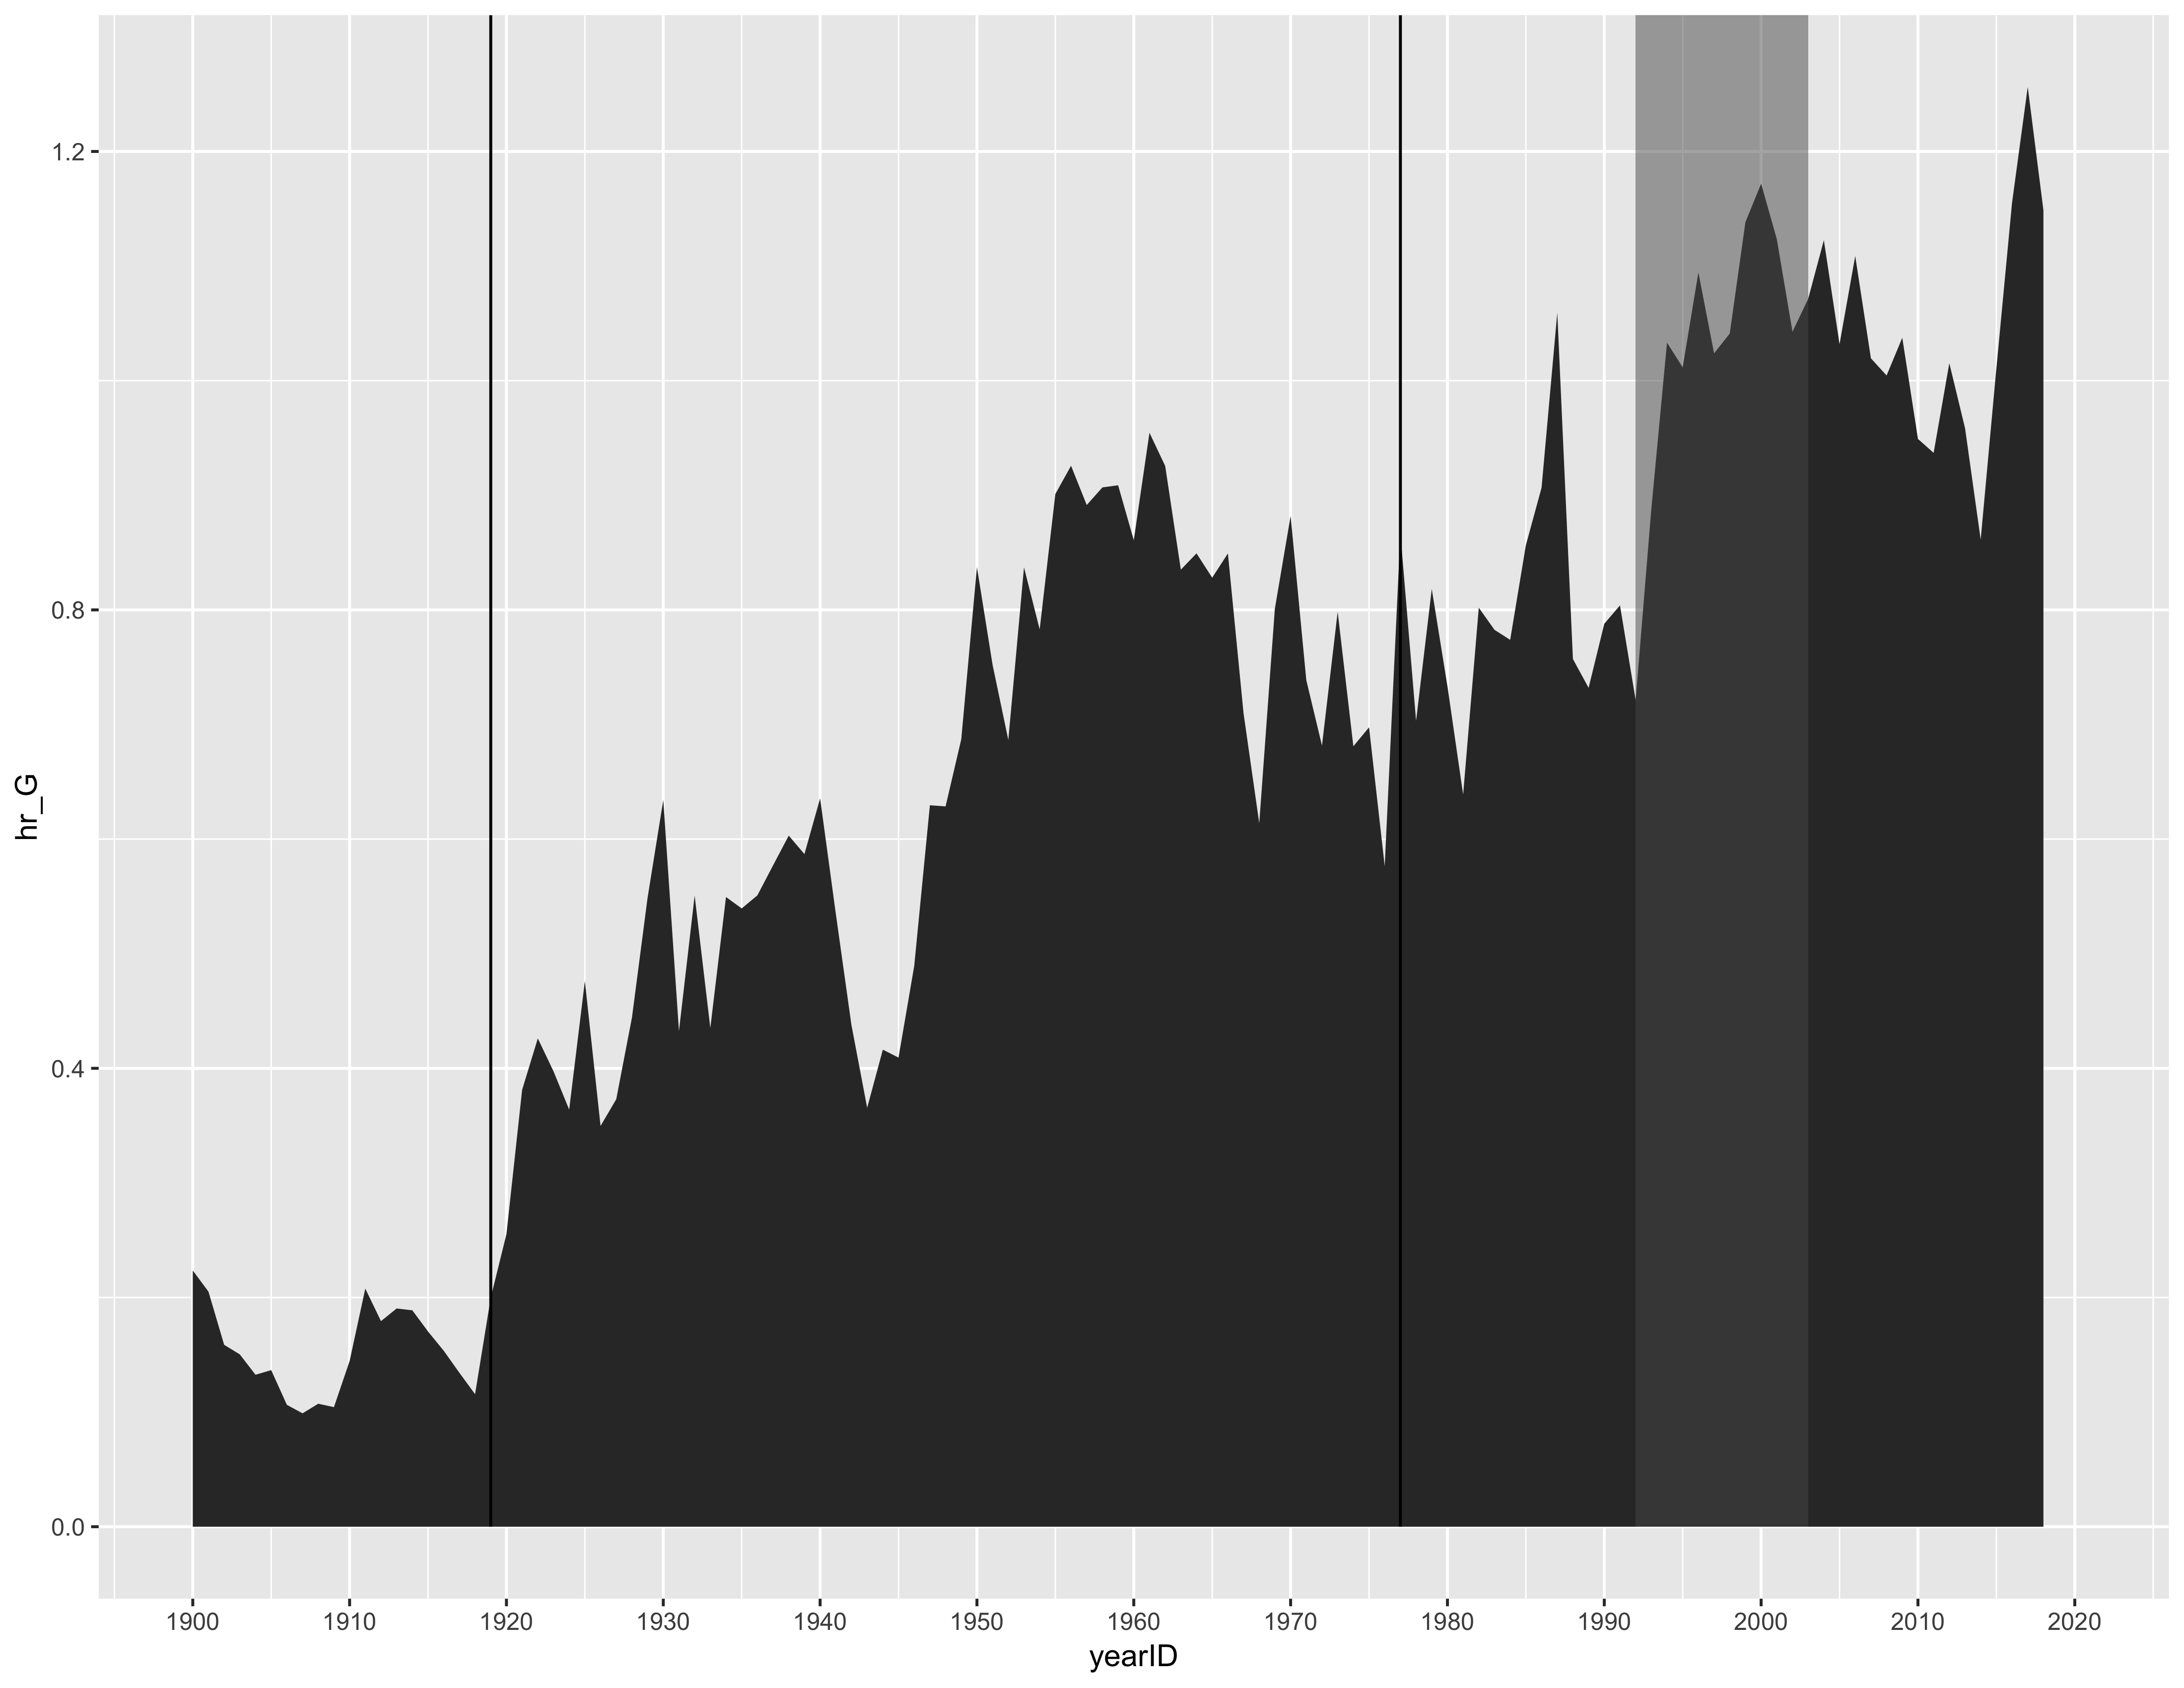

In [107]:
%%R -w 11 -h 8.5 --units in -r 400

ggplot() +
    geom_area(aes(x = yearID, y = hr_G), data = join) +
    geom_segment(aes(x = 1919, xend = 1919, y = 0, yend = Inf)) +
    geom_segment(aes(x = 1977, xend = 1977, y = 0, yend = Inf)) +
    geom_rect(aes(xmin = 1992, xmax = 2003, ymin = 0, ymax = Inf), alpha = 0.5) +
    scale_x_continuous(limits = c(1900, 2020), breaks = seq(1900, 2020, by = 10))